<a href="https://colab.research.google.com/github/GhazalehKeyvani/Data-Science-Exercises/blob/main/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ghazaleh Keyvani

#تعداد لایه‌های Conv2D (Encoder)

4 لایه با loss=0.85

افزایش لایه‌ها (مثلاً 6 لایه):

مزیت: استخراج ویژگی‌های پیچیده‌تر (دقت Segmentation بهبود می‌یابد).

معایب:

خطر اورفیتینگ افزایش می‌یابد.

مدل سنگین‌تر و زمان آموزش بیشتر می‌شود.

کاهش لایه‌ها (مثلاً 2 لایه):

مزیت: مدل سریع‌تر آموزش می‌بیند و سبک‌تر می‌شود.

معایب: دقت کاهش می‌یابد (ویژگی‌های کافی استخراج نمی‌شود).

#تعداد لایه‌های Conv2D (Decoder)
تعدادلایه ۴ با loss 0.85

تأثیر افزایش/کاهش لایه‌ها:

افزایش لایه‌ها (مثلاً 6 لایه):

مزیت: بازیابی جزئیات فضایی بهتر (مثلاً برای تصاویر با وضوح بالا).

معایب: ممکن است نویز یا آرتیفکت‌های مصنوعی در خروجی ایجاد شود.

کاهش لایه‌ها (مثلاً 2 لایه):

مزیت: مدل ساده‌تر و سریع‌تر می‌شود.

معایب: وضوح مکانی خروجی کاهش می‌یابد (اشیا کوچک به درستی segment نمی‌شوند).


استفاده از strides=1:

مزیت: حفظ جزئیات فضایی بهتر.

معایب: ابعاد feature maps تغییر نمی‌کند و مدل به حافظه و محاسبات بیشتری نیاز دارد.

استفاده از strides=3:

در کد های من سایز کاهش یافته و سایز ۱۲۸*۱۲۸ است به همین خاطر strides>=3 با خطا مواجه شد

مزیت: کاهش سریع‌تر ابعاد (مدل سریع‌تر اجرا می‌شود).

معایب: از دست رفتن اطلاعات مکانی و کاهش دقت.

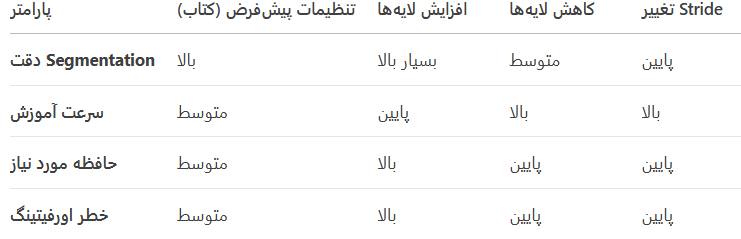

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

URL transformed to HTTPS due to an HSTS policy
--2025-05-05 15:40:32--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-05-05 15:40:32--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.2’

images.tar.gz.2     100%[===================>] 755.23M  25.3MB/s    in 31s     

2025-05-05 15:41:05 (24.1 MB/s) - ‘images.tar.gz.2’ saved [791918971/791918971]

URL transformed to HTTPS due to an HSTS policy
--2025-05

In [2]:
!pip install tensorflow matplotlib numpy

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

# Load and prepare the dataset
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

# Shuffle the data
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

# Define image size
img_size = (128, 128)
num_imgs = len(input_img_paths)

# Load images and masks
def path_to_input_image(path):
    img = tf.keras.utils.load_img(path, target_size=img_size)
    return tf.keras.utils.img_to_array(img)

def path_to_target(path):
    img = tf.keras.utils.load_img(path, target_size=img_size, color_mode="grayscale")
    img = tf.keras.utils.img_to_array(img)
    img = img.astype("uint8") - 1  # Convert labels to 0, 1, 2
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# Split into train and validation
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]





In [4]:
# Define the model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # Encoder (Downsampling)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

100/100 ━━━━━━━━━━━━━━━━━━━━ 133s 967ms/step - loss: 0.9783 - val_loss: 0.9596
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


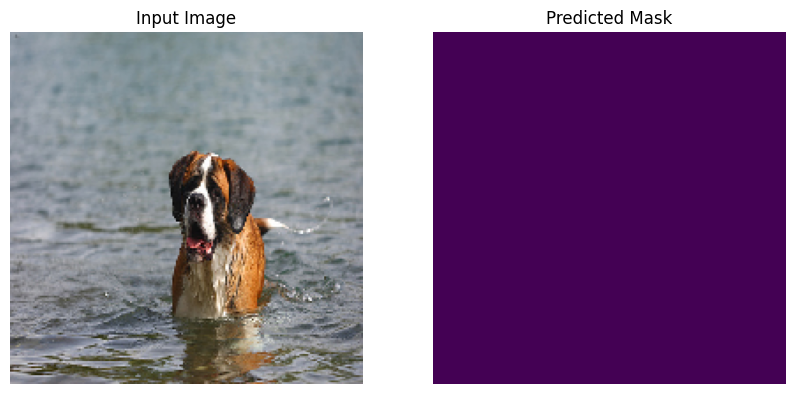

In [6]:
model = get_model(img_size=img_size, num_classes=3)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=1, callbacks=callbacks, batch_size=64, validation_data=(val_input_imgs, val_targets))

# Evaluate the model
model = keras.models.load_model("oxford_segmentation.keras")
test_image = val_input_imgs[0]
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

# Display input image and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(tf.keras.utils.array_to_img(test_image))
plt.title("Input Image")

plt.subplot(1, 2, 2)
display_mask(mask)
plt.title("Predicted Mask")
plt.show()

#2 layer encoder , decoder

In [2]:
# Define the model
def get_shorter_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # Encoder (Downsampling)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)


    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)


    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [3]:
model = get_shorter_model(img_size=img_size, num_classes=3)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=1, callbacks=callbacks, batch_size=16, validation_data=(val_input_imgs, val_targets))

# Evaluate the model
model = keras.models.load_model("oxford_segmentation.keras")
test_image = val_input_imgs[0]
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)



400/400 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - loss: 0.9066 - val_loss: 0.8908
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


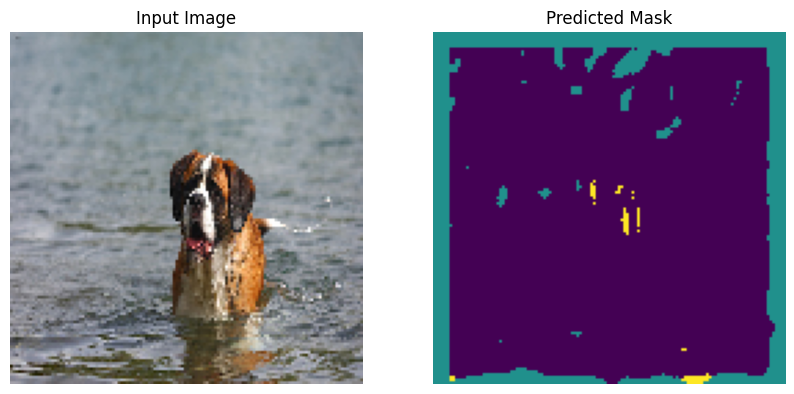

In [4]:
# Display input image and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(tf.keras.utils.array_to_img(test_image))
plt.title("Input Image")

plt.subplot(1, 2, 2)
display_mask(mask)
plt.title("Predicted Mask")
plt.show()

#strides=1 for encoder and decoder

In [5]:
# Define the model
def get_model_stride(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # Encoder (Downsampling)
    x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)



    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=1)(x)



    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [6]:
model = get_model_stride(img_size=img_size, num_classes=3)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=1, callbacks=callbacks, batch_size=16, validation_data=(val_input_imgs, val_targets))

# Evaluate the model
model = keras.models.load_model("oxford_segmentation.keras")
test_image = val_input_imgs[0]
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)



400/400 ━━━━━━━━━━━━━━━━━━━━ 105s 214ms/step - loss: 0.9061 - val_loss: 0.7985
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


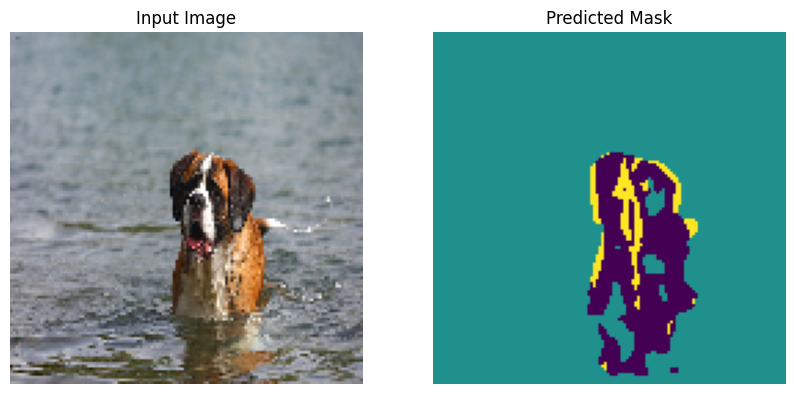

In [7]:
# Display input image and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(tf.keras.utils.array_to_img(test_image))
plt.title("Input Image")

plt.subplot(1, 2, 2)
display_mask(mask)
plt.title("Predicted Mask")
plt.show()

#strides=3 for encoder and decoder

In [13]:
# Define the model
def get_model_stride(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # Encoder (Downsampling)
    x = layers.Conv2D(64, 3, strides=5, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)



    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=1)(x)



    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [14]:
model = get_model_stride(img_size=img_size, num_classes=3)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=1, callbacks=callbacks, batch_size=16, validation_data=(val_input_imgs, val_targets))

# Evaluate the model
model = keras.models.load_model("oxford_segmentation.keras")
test_image = val_input_imgs[0]
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)



ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(None, 128, 128), output.shape=(None, 26, 26, 3)